In [1]:
import torch
import matplotlib.pyplot as plt
import torch
from torch.optim import LBFGS
import time
import os
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Definir la función legendre de forma vectorizada
def legendre(n, x):
    P0 = torch.ones_like(x)
    if n == 0:
        return P0
    P1 = x
    if n == 1:
        return P1
    for _ in range(2, n + 1):
        P0, P1 = P1, ((2 * _ - 1) * x * P1 - (_ - 1) * P0) / _
    return P1


# Evaluación de la serie de Legendre 2-D utilizando broadcasting
def evaluate_legendre_series(coefficients, leg_x, leg_y):
    n = int(torch.sqrt(torch.tensor(coefficients.numel()).float()))  # Convert to tensor before sqrt
    coefficients = coefficients.view(n, n)
    
    # Utilizando broadcasting para calcular la serie de Legendre
    result = torch.sum(coefficients[:, :, None, None] * leg_x[:, None, :, :] * leg_y[None, :, :, :], dim=(0, 1))
    
    return torch.atan(result) 

In [3]:
# Precomputar leg_x y leg_y una vez
start_precompute = time.time()

# Elige una suposición inicial para los coeficientes
N = 200  # Grado máximo de los polinomios de Legendre
initial_guess = torch.zeros(N*N, requires_grad=True, device=device)  # Suposición inicial para los coeficientes

# Datos de entrada para la función y los polinomios de Legendre
X1, X2 = torch.meshgrid(torch.linspace(0, 1, 100, device=device), torch.linspace(0, 1, 100, device=device))
 
n = int(torch.sqrt(torch.tensor(initial_guess.numel(), device=device).float()))
leg_x = torch.stack([legendre(i, X1).to(device) for i in range(n)], dim=0)
leg_y = torch.stack([legendre(j, X2).to(device) for j in range(n)], dim=0)
end_precompute = time.time()
time_precompute = end_precompute - start_precompute
print(f"Tiempo de precomputación de Legendre polynomials: {time_precompute:.4f} segundos")

/home/oscar-rincon/miniconda3/envs/ReScience-PINNs-env/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716578970623/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Tiempo de precomputación de Legendre polynomials: 1.9175 segundos


Tiempo de optimización: 5.8389 segundos
Tiempo de evaluación: 0.0002 segundos


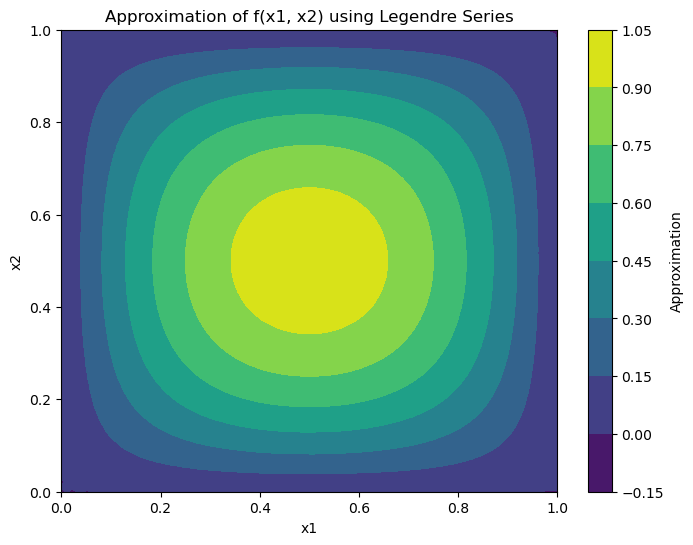

In [10]:
# Define la función para la cual quieres calcular los coeficientes de la serie de Legendre
def f(x1, x2):
    #return torch.sin(x1) * torch.cos(x2) + 0.5 * torch.cos(2*x1) * torch.cos(2*x2) + 0.25 * torch.cos(4*x1) * torch.cos(4*x2)
    return 16*(1 - x1) * x1 * (1 - x2) * x2
    #return x1*x2*(1-x1)*(1-x2)*torch.exp(x1-x2)

# Define la función de error
def error_function(coefficients, leg_x, leg_y):
    approximation = evaluate_legendre_series(coefficients, leg_x, leg_y)
    error = torch.mean((f(X1, X2) - approximation) ** 2)
    return error

# Usar una función de optimización para minimizar la función de error con respecto a los coeficientes
optimizer = LBFGS([initial_guess], lr=1)

def closure():
    optimizer.zero_grad()
    loss = error_function(initial_guess, leg_x, leg_y)
    loss.backward()
    return loss

# Realizar pasos de optimización
start_optimization = time.time()
for _ in range(5):  # Número de pasos de optimización
    optimizer.step(closure)
end_optimization = time.time()

# Coeficientes óptimos encontrados
optimal_coefficients = initial_guess.detach()

# Evaluar la aproximación de la serie de Legendre
start_evaluation = time.time()
approximation = evaluate_legendre_series(optimal_coefficients, leg_x, leg_y)
end_evaluation = time.time()

# Medir el tiempo de optimización y evaluación
time_optimization = end_optimization - start_optimization
time_evaluation = end_evaluation - start_evaluation

print(f"Tiempo de optimización: {time_optimization:.4f} segundos")
print(f"Tiempo de evaluación: {time_evaluation:.4f} segundos")

# Graficar el resultado usando contourf
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().numpy(), X2.cpu().numpy(), approximation.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Approximation')
plt.title('Approximation of f(x1, x2) using Legendre Series')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [11]:
# Calcular el error en la predicción
prediction_error = error_function(optimal_coefficients, leg_x, leg_y)

print(f"Error en la predicción: {prediction_error.item()}")

Error en la predicción: 2.1629796265187906e-07


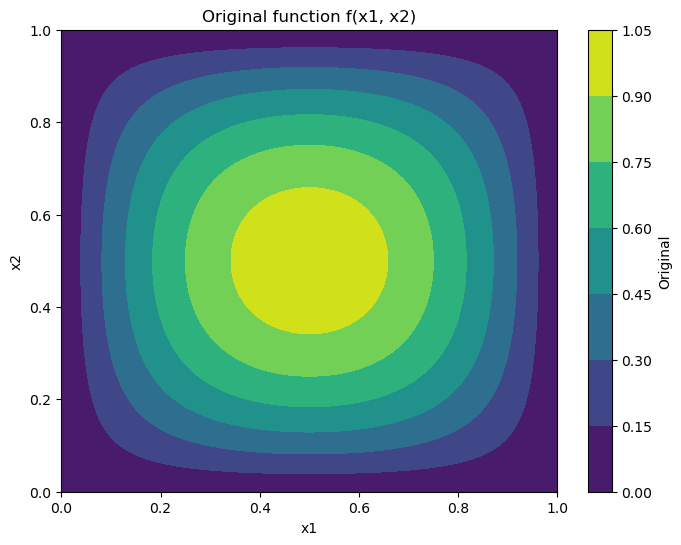

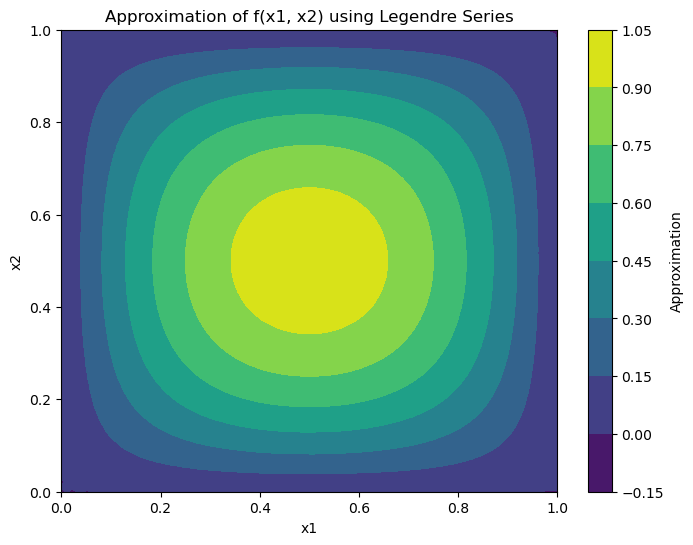

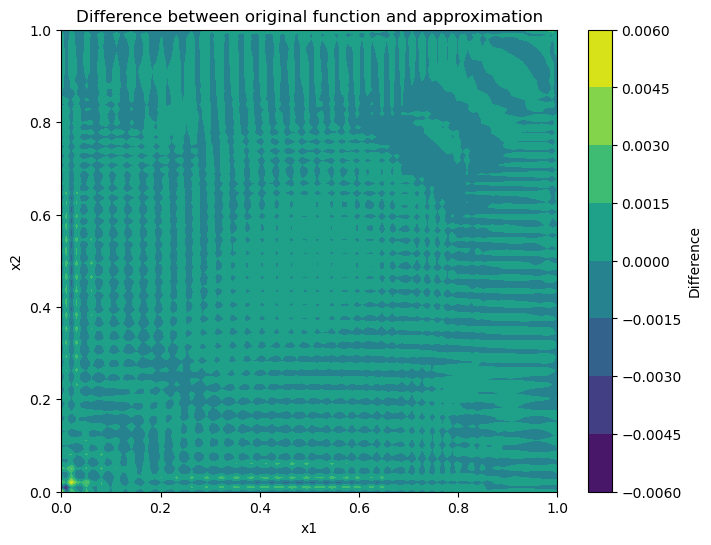

In [12]:
# Calcular la función original
original = f(X1, X2)

# Calcular la diferencia entre la función original y la aproximación
difference = original - approximation

# Graficar la función original
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().numpy(), X2.cpu().numpy(), original.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Original')
plt.title('Original function f(x1, x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Graficar la aproximación
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().numpy(), X2.cpu().numpy(), approximation.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Approximation')
plt.title('Approximation of f(x1, x2) using Legendre Series')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Graficar la diferencia
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().numpy(), X2.cpu().numpy(), difference.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Difference')
plt.title('Difference between original function and approximation')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()